In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats as st
from IPython.display import display, Markdown
from functools import reduce
import operator

from common_plotting import read_data, plot, years, months, yearsFmt, add_thp
from common_analysis import analyse_dcv, analyse_dcv_absolute, rel_data_cut_index_last, rel_data_cut_index_first, combine_stds_sum
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10,4)
plt.rc('font', size=14)

# Shared functions

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st

from common_plotting import read_data, plot, years, months, yearsFmt, add_thp

def analyse_dcv(absolute_data, relative_data, meter_absolute, meter_relative):
    absolute_results, absolute_ratios_in_ppm = analyse_dcv_absolute(absolute_data, 'D4910avg', meter_absolute)
    f7001_value = absolute_results[absolute_results.index == 'F7001bat'][['dcv_mean']].iloc[0,0]
    relative_results_in_ppm = analyse_dcv_relative(relative_data, 'F7001bat', f7001_value, 'D4910avg', meter_relative)
    return dcv_combine_absolute_and_relative(absolute_ratios_in_ppm, relative_results_in_ppm)

def analyse_dcv_k182(relative_data_k182):
    short_voltage = relative_data_k182[relative_data_k182.dut_pos_lead != 'short']['k182_dcv'].mean()
    relative_data = relative_data_k182[(relative_data_k182.dut_pos_lead != 'short')]
    results = analyse_dcv_relative(relative_data, 'F7001bat', 10, 'F7001bat', 'k182', short_voltage)
    return results


def analyse_dcv_k182_between_dates(relative_data_k182, start_timestamp, end_timestamp):
    relative_data = relative_data_k182[(relative_data_k182.dut_pos_lead != 'short')]
    relative_data = relative_data[(relative_data.index >= start_timestamp) & (relative_data.index <= end_timestamp)].copy()
    results = analyse_dcv_relative(relative_data, 'F7001bat', 10, 'F7001bat', 'k182')
    return results

def dcv_combine_absolute_and_relative(ratios_ppm, relative_results_in_ppm):
    combined = ratios_ppm.join(relative_results_in_ppm)
    combined.columns = ['temperature', 'abs_mean', 'abs_sem', 'rel_mean', 'rel_sem']
    return combined

def analyse_dcv_relative(relative_data, reference_name, reference_value, new_reference_name, meter, short_offset=0):
    filtered_data = relative_data[(relative_data.dut_neg_lead == reference_name) | (relative_data.dut_pos_lead == reference_name)].copy()
#     filtered_data = relative_dcv_substract_offset(filtered_data, meter, short_offset)
    relative_dcv_add_polarity(filtered_data, reference_name, meter)
    relative_results_in_ppm = relative_results_to_ppm(filtered_data, reference_name, reference_value, new_reference_name)
    
    if reference_name != new_reference_name:
        relative_results_in_ppm = retarget_reference(relative_results_in_ppm, reference_name, reference_value, new_reference_name)
    
    return relative_results_in_ppm


def analyse_dcv_absolute(absolute_data, reference_name, meter):
    absolute_data_with_groups = add_dut_and_setting_group(absolute_data)
    absolute_data = analyse_group_quality(absolute_data_with_groups, meter)
    absolute_data_first_and_last_in_group_removed = clean_groups(absolute_data_with_groups, meter)
    cleaned_absolute_data = aggregate_absolute_data_by_group(absolute_data_first_and_last_in_group_removed, meter)
    #display(cleaned_absolute_data)
    absolute_grouped_by_dut_group = aggregate_absolute_data_by_dut_group(cleaned_absolute_data, meter)
    absolute_results = absolute_grouped_by_dut_group.groupby('dut').agg({'dcv_mean': 'mean', 'dcv_sem': combine_stds_sum, 'temperature_mean': 'mean', 'datetime': 'mean'})
    ratios_from_absolute = dcv_calculate_ratios(absolute_grouped_by_dut_group, reference_name)
    ratios_in_ppm = absolute_results_to_ppm(ratios_from_absolute)
    return absolute_results, ratios_in_ppm

def combine_stds_sum(stds):
    return np.sqrt(np.sum(stds**2) / np.size(stds))

def combine_stds_ratio_product(product_or_ration_value, mean1, sem1, mean2, sem2):
    return np.abs(product_or_ration_value) * np.sqrt((sem1 / mean1)**2 + (sem2 / mean2)**2)

def add_dut_and_setting_group(data):
    data_groups = (data[['dut', 'dut_setting']].apply(tuple, axis=1) != data[['dut', 'dut_setting']].shift().apply(tuple, axis=1)).cumsum().rename('group')
    return data.join(data_groups)

def add_dut_neg_and_pos_group(data):
    data_groups = (data[['dut_neg_lead', 'dut_pos_lead']].apply(tuple, axis=1) != data[['dut_neg_lead', 'dut_pos_lead']].shift().apply(tuple, axis=1)).cumsum().rename('group')
    return data.join(data_groups)

def std_minus_first(series):
    return np.std(series.iloc[:-1])

def std_minus_last(series):
    return np.std(series.iloc[1:])

def analyse_group_quality(data, meter):
    groups = data.groupby('group').agg({f'{meter}_dcv': ['std', std_minus_first, std_minus_last]})
    return data
    

def clean_groups(data, meter):
    groups = data.groupby('group').apply(lambda x: x.iloc[1:-1]).droplevel(0)
    quality = groups.groupby('group').agg({f'{meter}_dcv': 'std', 'dut': 'last'})
    bad_group_index = quality[f'{meter}_dcv'] >= 1e-6
    if bad_group_index.any():
        bad_groups = quality[bad_group_index]
        display("Found bad groups:")
        display(bad_groups)
        return groups[~groups.group.isin(bad_groups.index)]
    return groups

def aggregate_absolute_data_by_group(data, meter):
    return data.reset_index().groupby('group').agg({f'{meter}_dcv': ['mean', 'std', 'sem', 'count'], 'temperature': ['mean', 'std', 'sem', 'count'], 'dut': 'last', 'dut_setting': 'last', 'datetime': 'mean'})

def aggregate_absolute_data_by_dut_group(absolute_dcv_data, meter):
    data_with_dut_group = absolute_dcv_data.copy()
    # display(absolute_dcv_data)
    data_with_dut_group['dut_group'] = (data_with_dut_group['dut']['last'] != data_with_dut_group['dut']['last'].shift(1)).cumsum()
    # display(    data_with_dut_group)
    # display((data_with_dut_group['dut']['last'] != data_with_dut_group['dut']['last'].shift(-1)))
    data_with_dut_group.columns = ['_'.join(col) for col in data_with_dut_group.columns.values]
    data_grouped_by_dut = data_with_dut_group.groupby('dut_group_').agg(
        {'dut_last': 'last', f'{meter}_dcv_mean': lambda v: np.mean(np.abs(v)), (f'{meter}_dcv_sem'): combine_stds_sum, 'temperature_mean': 'mean', 'datetime_mean': 'mean'})
    data_grouped_by_dut.columns = ['dut', 'dcv_mean', 'dcv_sem', 'temperature_mean', 'datetime']
    # display(data_grouped_by_dut)
    # display(    data_with_dut_group)
    return data_grouped_by_dut


def dcv_calculate_ratios(grouped_by_dut, reference):
    refs = grouped_by_dut[grouped_by_dut.dut == reference]
    duts = grouped_by_dut[grouped_by_dut.dut != reference]
    ratio_input = duts.apply(lambda x: dcv_add_prev_and_next_refs(refs, grouped_by_dut, x.name), axis=1)

    ratios_before_input = ratio_input[~ratio_input.dut_before.isna()].copy()
    ratios_before_input['ratio'] = ratios_before_input.dcv_mean / ratios_before_input.dcv_mean_before
    ratios_before_input['ratio_sem'] = combine_stds_ratio_product(ratios_before_input.ratio, ratios_before_input.dcv_mean, ratios_before_input.dcv_sem,
                                                                  ratios_before_input.dcv_mean_before, ratios_before_input.dcv_sem_before)

    ratios_after_input = ratio_input[~ratio_input.dut_after.isna()].copy()
    ratios_after_input['ratio'] = ratios_after_input.dcv_mean / ratios_after_input.dcv_mean_after
    ratios_after_input['ratio_sem'] = combine_stds_ratio_product(ratios_after_input.ratio, ratios_after_input.dcv_mean, ratios_after_input.dcv_sem,
                                                                 ratios_after_input.dcv_mean_after, ratios_after_input.dcv_sem_after)

    ratios_before_and_after = pd.concat(
        [ratios_before_input[['dut', 'ratio', 'ratio_sem', 'temperature_mean']], ratios_after_input[['dut', 'ratio', 'ratio_sem', 'temperature_mean']]])
    ratios_from_absolute = ratios_before_and_after.groupby('dut').agg({'ratio': 'mean', 'ratio_sem': combine_stds_sum, 'temperature_mean': 'mean'})
    ratios_from_absolute = pd.concat([ratios_from_absolute, pd.DataFrame({'ratio': 1, 'ratio_sem': 0, 'temperature_mean': np.nan}, index=(reference,))])
    return ratios_from_absolute


def dcv_add_prev_and_next_refs(refs, duts, dut_index):
    refs_with_dut = refs.copy()
    refs_with_dut.loc[dut_index] = duts.loc[dut_index]
    refs_with_dut.sort_index(inplace=True)
    return pd.concat([refs_with_dut, refs_with_dut.shift(1).add_suffix('_before'), refs_with_dut.shift(-1).add_suffix('_after')], axis=1).loc[dut_index]



def relative_dcv_add_polarity(data, reference_name, meter):
    data['polarity'] = data.dut_neg_lead.apply(lambda dut: 'positive' if dut == reference_name else 'negative')
    data['dut'] = data.apply(lambda row: row.dut_neg_lead if row.polarity == 'negative' else row.dut_pos_lead, axis=1)
    data.loc[data['polarity'] == 'positive','corrected_value'] = data[f'{meter}_dcv']
    data.loc[data['polarity'] == 'negative','corrected_value'] = -data[f'{meter}_dcv']
    check_sign(data, meter)


def check_sign(data, meter):
    data['sign'] = (data[f'{meter}_dcv'] / data[f'{meter}_dcv'].abs())
    check_sign_data = data.reset_index().groupby(['dut', 'polarity']).agg({'sign': 'unique', 'datetime': 'first'})
    check_sign_data['sign_length'] = check_sign_data['sign'].apply(lambda r: len(r))
    sign_failures = check_sign_data[check_sign_data.sign_length > 1]
    if not sign_failures.empty:
        display("Sign flip in measurement with same reported polarity and dut")
        display(sign_failures)
        for dut in sign_failures.reset_index().dut.unique():
            display(data[data.dut == dut])


def relative_dcv_substract_offset(relative_data, meter, short_offset):
    relative_data[f'{meter}_dcv'] -= short_offset
    return relative_data


def relative_results_to_ppm(relative_data, reference_name, reference_value, new_reference_name):
    grouped_by_dut_polarity = relative_data.reset_index().groupby(['dut', 'polarity']) \
        .agg({'corrected_value': ['mean', 'std', 'sem', 'count'], 'datetime': 'mean', 'temperature': 'mean', 'pressure': 'mean', 'humidity': 'mean'}).reset_index()
    grouped_by_dut_polarity.columns = ('dut', 'polarity', 'mean', 'std', 'sem', 'count', 'datetime', 'temperature', 'pressure', 'humidity')
    relative_results = grouped_by_dut_polarity.groupby('dut').agg({'mean': 'mean', 'sem': combine_stds_sum, 'datetime': 'mean', 'temperature': 'mean', 'pressure': 'mean', 'humidity': 'mean'})
    relative_results_in_ppm = pd.DataFrame()
    relative_results_in_ppm.index = relative_results.index
    relative_results_in_ppm['mean_in_ppm'] = (relative_results['mean'] / reference_value) * 1e6
    relative_results_in_ppm['sem_in_ppm'] = (relative_results['sem'] / reference_value) * 1e6
    relative_results_in_ppm['datetime'] = relative_results['datetime']
    relative_results_in_ppm['temperature'] = relative_results.temperature
    relative_results_in_ppm['pressure'] = relative_results.pressure
    relative_results_in_ppm['humidity'] = relative_results.humidity
    return relative_results_in_ppm


def retarget_reference(relative_results_in_ppm, reference_name, new_reference_name):
    relative_results_in_ppm = pd.concat([relative_results_in_ppm, pd.DataFrame({'mean_in_ppm': 0, 'sem_in_ppm': 0}, index=(reference_name,))])
    relative_results_in_ppm['mean_in_ppm'] = relative_results_in_ppm[relative_results_in_ppm.index == new_reference_name].mean_in_ppm.iloc[0]-relative_results_in_ppm.mean_in_ppm
    relative_results_in_ppm['sem_in_ppm'] = np.sqrt(relative_results_in_ppm[relative_results_in_ppm.index == new_reference_name].sem_in_ppm.iloc[0]**2+relative_results_in_ppm.sem_in_ppm**2)
    return relative_results_in_ppm


def absolute_results_to_ppm(ratios):
    ratios_ppm = ratios.copy().drop(['ratio', 'ratio_sem'], axis=1)
    ratios_ppm['ppm_diff'] = (1-ratios.ratio) * 1e6
    ratios_ppm['ppm_sem'] = ratios.ratio_sem * 1e6
    return ratios_ppm


def flatten_relative_dcv_result(rel_results: pd.DataFrame, mean: float, mean_sem:float):
    rows = rel_results.apply(lambda row: {
        (row.name, 'datetime'): row.datetime,
        (row.name, 'mean'): row.mean_in_ppm - mean,
        (row.name, 'sem'): combine_stds_sum(np.array(row.sem_in_ppm, mean_sem)) if not np.isnan(row.sem_in_ppm) else np.nan,
        (row.name, 'temperature'): row.temperature,
        (row.name, 'pressure'): row.pressure,
        (row.name, 'humidity'): row.humidity
        },
        axis=1)
    return reduce(operator.ior, rows, {})

def get_result_from_group(result):
    result = result.append(pd.Series({
        'mean_in_ppm': 0,
        'sem_in_ppm': combine_stds_sum(result.sem_in_ppm.dropna()),
        'datetime': result.datetime.mean(),
        'temperature': result.temperature.mean(),
        'pressure': result.pressure.mean(),
        'humidity': result.humidity.mean(),
        }, name='F7001bat'))
    results_wo_d4910avg = result[(result.index != 'D4910avg') & (result.index.isin(voltage_references))]
    population_mean = results_wo_d4910avg.mean_in_ppm.mean()
    if np.isnan(population_mean):
        return None
    population_sem = combine_stds_sum(results_wo_d4910avg.sem_in_ppm)
    # print(f"{result.datetime.mean()} mean: {population_mean}, sem: {population_sem}")
    flat_result = flatten_relative_dcv_result(result, population_mean, population_sem)
    return flat_result

# Load data

In [3]:
thp_data, data = read_data(['ks3458a1-dcv-log.csv', 'ks3458a1-dcv-mv-log.csv', 'k182-dcv-mv-log.csv', 'ks3458a-dcv-log.csv'])
absolute_data_3458a_1 = data['ks3458a1-dcv-log.csv']
absolute_data_3458a_2 = data['ks3458a-dcv-log.csv']
relative_data_3458a = data['ks3458a1-dcv-mv-log.csv']
relative_data_k182 = data['k182-dcv-mv-log.csv']


# Main analysis

In [26]:
from common_analysis import abs_data_cut_index_last


k182_rel_data_copy = relative_data_k182.copy()
k182_rel_data_copy['gap'] = k182_rel_data_copy.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_copy['group'] = k182_rel_data_copy.gap.cumsum()
cut_1 = rel_data_cut_index_last(k182_rel_data_copy, 1, 'F732a2', 'D4910avg', pd.Timedelta('40 minutes'))
k182_rel_data_cut = k182_rel_data_copy[~cut_1].copy()
k182_rel_data_cut['gap'] = k182_rel_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
k182_rel_data_cut['group'] = k182_rel_data_cut.gap.cumsum()

ag3458a_rel_data = relative_data_3458a.copy()
ag3458a_rel_data['gap'] = ag3458a_rel_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_rel_data['group'] = ag3458a_rel_data.gap.cumsum()

ag3458a_1_abs_data = absolute_data_3458a_1.copy()
ag3458a_1_abs_data['gap'] = ag3458a_1_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data['group'] = ag3458a_1_abs_data.gap.cumsum()
cut_1 = abs_data_cut_index_last(ag3458a_1_abs_data, 2, 'D4910avg', '10 V', pd.Timedelta('4 minutes'), pd.Timestamp('2021-11-17T21:38:19'))
cut_2 = (ag3458a_1_abs_data.index > pd.Timestamp('2021-11-17T23:49:12')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-04-18T21:35:20'))
cut_3 = (ag3458a_1_abs_data.index > pd.Timestamp('2022-04-19T02:11:40')) & (ag3458a_1_abs_data.index < pd.Timestamp('2022-08-09T22:49:55'))
ag3458a_1_abs_data_cut = ag3458a_1_abs_data[~cut_1 & ~cut_2 & ~cut_3].copy()
ag3458a_1_abs_data_cut['gap'] = ag3458a_1_abs_data_cut.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_1_abs_data_cut['group'] = ag3458a_1_abs_data_cut.gap.cumsum()

cut_1 = (absolute_data_3458a_2.index > pd.Timestamp('2021-09-10T10:08:00')) & (absolute_data_3458a_2.index < pd.Timestamp('2021-09-12T22:17:24'))
ag3458a_2_abs_data = absolute_data_3458a_2[~cut_1].copy()
ag3458a_2_abs_data['gap'] = ag3458a_2_abs_data.index.to_series().diff() > pd.Timedelta('3 hours')
ag3458a_2_abs_data['group'] = ag3458a_2_abs_data.gap.cumsum()


<AxesSubplot:xlabel='datetime'>

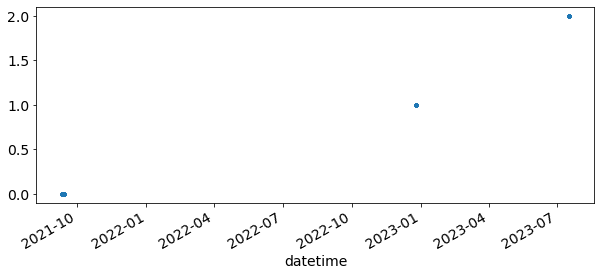

In [24]:
ag3458a_2_abs_data['group'].plot(style='.')

In [75]:
voltage_references = ('F732a1', 'F732a2', 'F732a3', 'D4910avg', 'D4910-1', 'D4910-2', 'D4910-3', 'D4910-4', 'F7001bat')
columns = [(dut, param) for dut in voltage_references for param in ('datetime', 'mean', 'sem', 'temperature', 'pressure', 'humidity')]
results = []
for group in ag3458a_rel_data.group.unique():
    group_samples = ag3458a_rel_data[ag3458a_rel_data.group == group].copy()
    result = analyse_dcv_relative(group_samples, 'F7001bat', 10, 'F7001bat', 'ag3458a_1', 0)
    flat_result = get_result_from_group(result)
    if flat_result is None:
        continue
    results.append(flat_result)
for group in k182_rel_data_cut.group.unique():
    group_samples = k182_rel_data_cut[k182_rel_data_cut.group == group].copy()
    result = analyse_dcv_k182(group_samples)
    flat_result = get_result_from_group(result)
    if flat_result is None:
        continue
    results.append(flat_result)
orig_max_cols = pd.get_option('display.max_columns')
# rel_results = pd.DataFrame(results, columns=pd.MultiIndex.from_tuples(columns), index=k182_rel_data_cut.group.unique())
rel_results = pd.DataFrame(results, columns=pd.MultiIndex.from_tuples(columns))
pd.set_option('display.max_columns', None)
display(rel_results)
pd.set_option('display.max_columns', orig_max_cols)

F732a1                                   \
                        datetime       mean       sem temperature   
0  2022-08-10 02:42:04.326365952  17.186949  0.002508   34.877467   
1  2022-08-25 11:22:17.590431744  17.157302  0.002438   37.619157   
2                            NaT        NaN       NaN         NaN   
3  2022-08-29 14:37:56.017542400  17.011332  0.000651   37.508195   
4  2022-09-21 15:20:56.923994624  17.362201  0.003566   31.926506   
5  2022-12-22 21:38:08.994086400  17.488942  0.003949   27.895061   
6  2023-01-14 18:56:41.392179712  17.824152  0.003604   25.945197   
7  2023-01-22 01:19:35.432957440  17.684561  0.004085   24.418316   
8  2023-01-25 22:41:22.304952832  17.767971  0.004745   25.170996   
9                            NaT        NaN       NaN         NaN   
10 2023-01-27 23:36:17.341893120  17.620580  0.003345   28.350979   
11                           NaT        NaN       NaN         NaN   
12 2023-01-28 15:07:23.155353088  17.308609  0.003931   31.665460   
13 2023-03-02 01:59:41.804903168  17.635065  0.003806   28.327617   
14 2023-06-24 21:42:10.059316224  17.524413  0.003318   32.858124   
15 2023-07-16 20:50:56.948048384  17.805266  0.002518   33.153038   
16 2023-07-22 23:25:36.147859968  17.788463  0.003867   33.801844   

                                                  F732a2                       \
       pressure   humidity                      datetime       mean       sem   
0   1027.884677  31.436515 2022-08-10 03:01:26.240461824  14.476606  0.003114   
1   1015.337532  28.855276 2022-08-25 11:38:27.978521344  14.440377  0.003885   
2           NaN        NaN                           NaT        NaN       NaN   
3   1022.579408  23.654013 2022-08-29 13:43:49.964445696  14.360062  0.000814   
4   1026.429435  22.709645 2022-09-21 15:28:52.841974784  14.710786  0.003241   
5   1002.113863  33.452271 2022-12-22 21:34:38.862407168  14.731516  0.004298   
6    995.474800  36.025571 2023-01-14 18:53:07.648848896  15.017771  0.004221   
7   1034.795595  27.565945 2023-01-22 01:24:01.665231104  14.944496  0.001685   
8   1025.835012  26.277449 2023-01-26 00:26:54.946850304  14.934590  0.008860   
9           NaN        NaN 2023-01-26 08:23:30.832382208  20.269159  0.007190   
10  1030.047550  27.095842 2023-01-27 23:28:51.173477376  14.902803  0.004598   
11          NaN        NaN 2023-01-28 06:06:57.842015232  20.277736  0.005398   
12  1030.152193  25.268042 2023-01-28 15:03:11.508902912  14.510012  0.005300   
13  1025.493539  22.894800 2023-03-02 01:56:20.820233728  14.840549  0.004686   
14  1021.945571  33.201811 2023-06-24 21:35:13.448096768  14.652576  0.004468   
15  1013.870446  30.129140 2023-07-16 20:44:57.703027456  14.910612  0.002956   
16  1009.919901  32.507132 2023-07-22 23:30:20.788241408  14.812076  0.003170   

                                                              F732a3  \
   temperature     pressure   humidity                      datetime   
0    34.819442  1027.887984  31.265190 2022-08-10 02:51:34.409591808   
1    37.677573  1015.255665  28.696644 2022-08-25 11:44:08.448907520   
2          NaN          NaN        NaN                           NaT   
3    37.120882  1022.884395  23.581948 2022-08-29 11:25:53.247917056   
4    32.455406  1026.352040  21.831325 2022-09-21 15:24:50.224551680   
5    27.719199  1002.049425  33.660435 2022-12-22 21:42:19.887340032   
6    25.936919   995.468495  35.979581 2023-01-14 18:50:16.263861248   
7    24.285600  1034.790586  27.475825 2023-01-22 01:36:55.545875712   
8    24.652354  1025.155756  25.828323 2023-01-26 00:12:51.405470720   
9    26.475819  1025.229465  28.487566 2023-01-26 08:25:27.378796032   
10   28.508733  1030.139306  26.883538 2023-01-27 23:32:20.678178304   
11   28.210090  1030.512973  27.087796 2023-01-28 06:09:22.856514560   
12   31.562729  1030.144740  25.193714 2023-01-28 14:58:13.347951616   
13   28.426128  1025.530239  22.618610 2023-03-02 01:53:24.803950592   
14   32.525971  1021.9

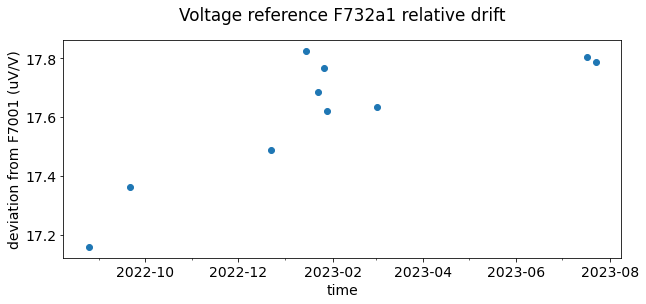

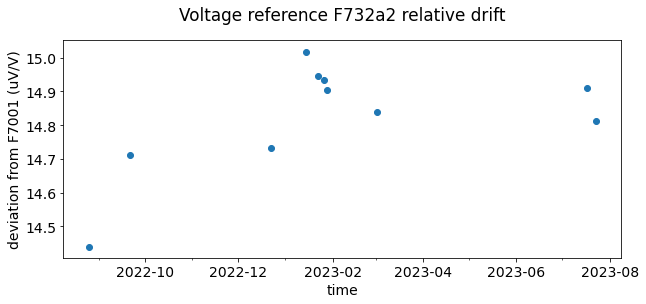

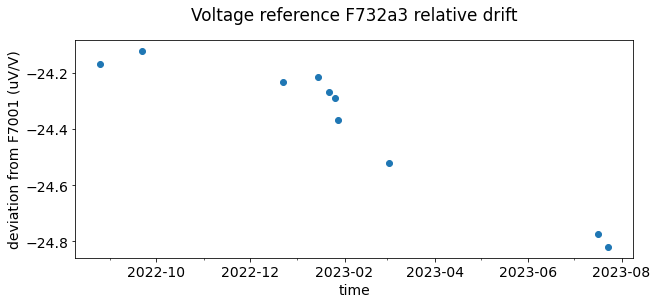

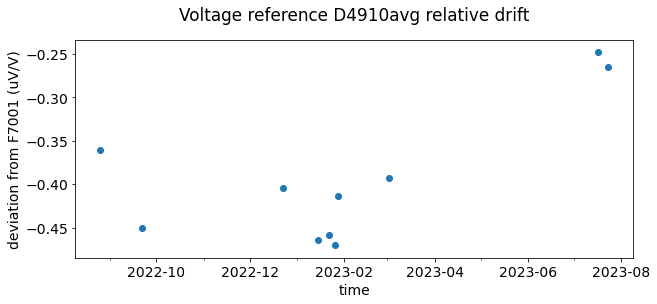

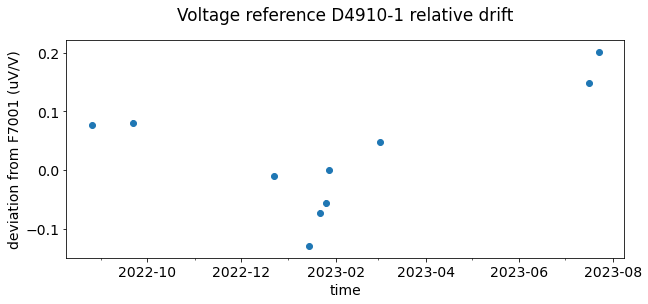

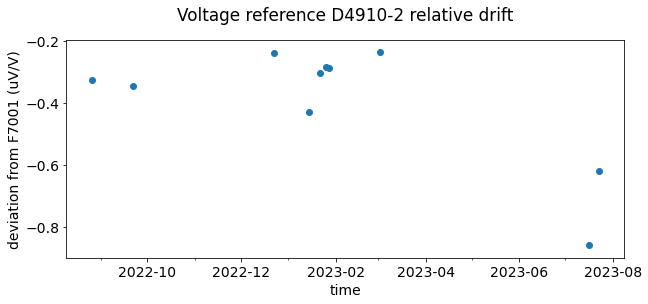

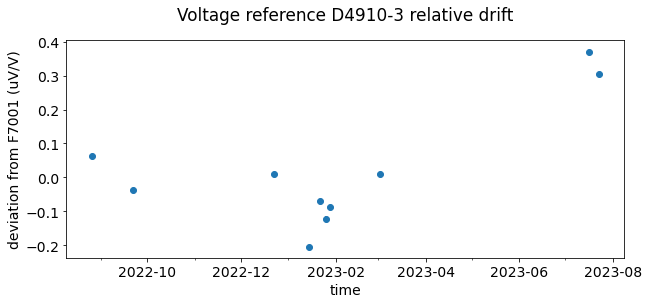

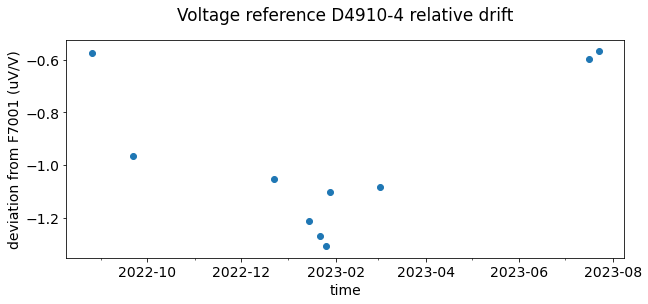

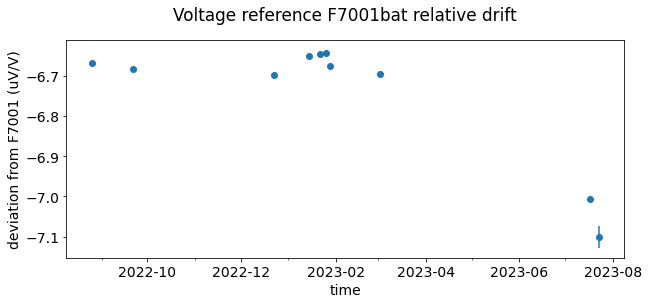

In [58]:
plt.rcParams["figure.figsize"] = (10,4)

# rel_results[[(ref, param) for ref in voltage_references for param in ('mean', 'sem', 'datetime')]]
rel_results = rel_results.dropna()
for ref in voltage_references:  
    plt.errorbar(rel_results[(ref, 'datetime')].dropna(), rel_results[(ref, 'mean')].dropna(), yerr=rel_results[(ref, 'sem')].dropna(), label=ref, fmt='o')
    plt.xlabel('time')
    plt.ylabel('deviation from F7001 (uV/V)')
    plt.title(f'Voltage reference {ref} relative drift', pad=20)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
    plt.show()

# Old analysis

## 2021-09-10

In [3]:
absolute_data_2021_09_10 = absolute_data_3458a_2[absolute_data_3458a_2.index < pd.Timestamp(2021,9,10,10,10)]
abs_2022_09_10, dcv_results_2022_09_10 = analyse_dcv_absolute(absolute_data_2021_09_10, 'F7001-SMPS-Au799ln', 'ag3458a_2')
display(dcv_results_2022_09_10)
display(abs_2022_09_10)

,temperature_mean,ppm_diff,ppm_sem
D4910avg,32.918002,-6.114349,0.007134
F732a2,33.018164,-20.742024,0.025198
F7001-SMPS-Au799ln,NaN,0.000000,0.000000


,dcv_mean,dcv_sem,temperature_mean
dut,,,
D4910avg,10.000036,4.029058e-08,32.918002
F7001-SMPS-Au799ln,9.999975,5.887748e-08,33.009654
F732a2,10.000182,2.450000e-07,33.018164


## 2021-09-12

In [4]:
absolute_data_2021_09_13 = absolute_data_3458a_2[(absolute_data_3458a_2.index > pd.Timestamp(2021,9,12,22,30)) & (absolute_data_3458a_2.index < pd.Timestamp(2021,9,13,0,0))]
abs_2022_09_13, dcv_results_2022_09_13 = analyse_dcv_absolute(absolute_data_2021_09_13, 'F7001', 'ag3458a_2')
display(dcv_results_2022_09_13)
display(abs_2022_09_13)

,temperature_mean,ppm_diff,ppm_sem
D4910avg,30.118697,-5.845180,0.007267
F7001-SMPS-Au799ln,29.111544,0.051400,0.006657
F732a1,29.281854,-22.973311,0.006303
F732a2,29.336272,-20.722960,0.006808
F732a3,29.250404,15.357066,0.005972
F7001,NaN,0.000000,0.000000


,dcv_mean,dcv_sem,temperature_mean
dut,,,
D4910avg,10.000046,5.573510e-08,30.118697
F7001,9.999986,4.838054e-08,29.571549
F7001-SMPS-Au799ln,9.999982,4.688039e-08,29.111544
F732a1,10.000217,3.686388e-08,29.281854
F732a2,10.000194,4.496416e-08,29.336272
F732a3,9.999834,3.087531e-08,29.250404


## 2022-08-09

In [5]:
absolute_data_2022_08_09 = absolute_data_3458a_1[absolute_data_3458a_1['last_acal_1'] == '2022-08-09T22:42:58.011500']
absolute_data_2022_08_09 = absolute_data_2022_08_09[absolute_data_2022_08_09['dut'] != 'F7001']
dcv_2022_08_09 = analyse_dcv(absolute_data_2022_08_09, relative_data_3458a, 'ag3458a_1', 'ag3458a_1')
display(dcv_2022_08_09)

'Found bad groups:'

,ag3458a_1_dcv,dut
group,,
26,0.000035,D4910-2


,temperature,abs_mean,abs_sem,rel_mean,rel_sem
D4910-1,35.187786,-0.321278,0.009411,-0.290235,0.007593
D4910-2,35.658993,-0.019317,0.009324,-0.097546,0.007923
D4910-3,35.537879,-0.299481,0.014092,-0.468137,0.007399
D4910-4,35.175105,0.349743,0.010765,0.305701,0.007322
F7001bat,35.095278,6.204112,0.008210,6.484320,0.006513
F732a1,34.947451,-17.648101,0.008133,-17.498447,0.006980
F732a2,35.229418,-14.898526,0.012779,-14.788090,0.007220
F732a3,34.957188,23.755563,0.009924,23.861170,0.006794
D4910avg,NaN,0.000000,0.000000,0.000000,0.009211


## 2022-08-25 #1

In [38]:
absolute_data_2022_08_25_1 = absolute_data_3458a_1[absolute_data_3458a_1['last_acal_1'] == '2022-08-25T10:37:27.993489']
relative_data_2022_08_25_1 = relative_data_k182[(relative_data_k182.dut_pos_lead != 'short')]
relative_data_2022_08_25_1 = relative_data_2022_08_25_1[relative_data_2022_08_25_1.index < pd.Timestamp(2022,8,25,16)]
dcv_2022_08_25_1 = analyse_dcv(absolute_data_2022_08_25_1, relative_data_2022_08_25_1, 'ag3458a_1', 'k182')
display(dcv_2022_08_25_1)

'Found bad groups:'

,ag3458a_1_dcv,dut
group,,
23,0.000007,F732a2
31,0.012915,F7001bat
39,0.028177,F7001bat


,temperature,abs_mean,abs_sem,rel_mean,rel_sem
D4910-1,37.726087,-0.281624,0.009442,-0.437808,0.003431
D4910-2,37.556162,-0.030015,0.008038,-0.033919,0.003787
D4910-3,37.427600,-0.420592,0.007651,-0.424565,0.004838
D4910-4,37.209281,0.352034,0.008463,0.212654,0.003569
F7001bat,39.385343,6.424656,0.007820,6.308407,0.001271
F732a1,37.831020,-17.568476,0.008466,-17.518465,0.002749
F732a2,38.092979,-14.870846,0.007340,-14.800509,0.004332
F732a3,38.002569,23.778382,0.007521,23.806758,0.001686
D4910avg,NaN,0.000000,0.000000,0.000000,0.001797


## 2022-08-25 #2

In [6]:
absolute_data_2022_08_25_2 = absolute_data_3458a_1[absolute_data_3458a_1['last_acal_1'] == '2022-08-25T10:37:27.993489']
relative_data_2022_08_25_2 = relative_data_k182[(relative_data_k182.dut_pos_lead != 'short')]
relative_data_2022_08_25_2 = relative_data_2022_08_25_2[(relative_data_2022_08_25_2.index > pd.Timestamp(2022,8,25,16)) & (relative_data_2022_08_25_2.index < pd.Timestamp(2022,8,26,0))]
dcv_2022_08_25_2 = analyse_dcv(absolute_data_2022_08_25_2, relative_data_2022_08_25_2, 'ag3458a_1', 'k182')
display(dcv_2022_08_25_2)

'Found bad groups:'

,ag3458a_1_dcv,dut
group,,
23,0.000007,F732a2
31,0.012915,F7001bat
39,0.028177,F7001bat


,temperature,abs_mean,abs_sem,rel_mean,rel_sem
D4910-1,37.726087,-0.281624,0.009442,NaN,NaN
D4910-2,37.556162,-0.030015,0.008038,NaN,NaN
D4910-3,37.427600,-0.420592,0.007651,NaN,NaN
D4910-4,37.209281,0.352034,0.008463,NaN,NaN
F7001bat,39.385343,6.424656,0.007820,6.543820,0.000792
F732a1,37.831020,-17.568476,0.008466,NaN,NaN
F732a2,38.092979,-14.870846,0.007340,-8.198148,0.000819
F732a3,38.002569,23.778382,0.007521,NaN,NaN
D4910avg,NaN,0.000000,0.000000,0.000000,0.001120



## 2022-08-29

In [133]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2022,8,29,0), pd.Timestamp(2022,8,31,0))

,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity
dut,,,,,,
D4910avg,6.325167,0.000377,2022-08-29 19:33:12.998833408,37.553076,1021.340352,24.686187
F732a1,23.974241,0.000651,2022-08-29 14:37:56.017542400,37.508195,1022.579408,23.654013
F732a2,21.322970,0.000814,2022-08-29 13:43:49.964445696,37.120882,1022.884395,23.581948
F732a3,-17.445577,0.001121,2022-08-29 11:25:53.247917056,36.152441,1023.289524,24.938915


## 2022-09-21

In [64]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2022,9,21,0), pd.Timestamp(2022,9,22,0))

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,6.763187,0.004560
D4910-2,6.336515,0.002674
D4910-3,6.646912,0.003172
D4910-4,5.719434,0.003684
D4910avg,6.232962,0.001539
D4910avg-bat,6.240694,0.002025
F732a1,24.045509,0.003566
F732a2,21.394095,0.003241
F732a3,-17.439186,0.002592


## 2022-12-22

In [65]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2022,12,22,0), pd.Timestamp(2022,12,24,0))

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,6.688159,0.003541
D4910-2,6.460146,0.003496
D4910-3,6.709578,0.004723
D4910-4,5.647943,0.003804
D4910avg,6.293985,0.000573
F732a1,24.187865,0.003949
F732a2,21.430439,0.004298
F732a3,-17.532750,0.002963


## 2023-01-14

In [66]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,14,0), pd.Timestamp(2023,1,15,0))

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,6.522008,0.003034
D4910-2,6.223326,0.003172
D4910-3,6.447954,0.003997
D4910-4,5.438480,0.002397
D4910avg,6.187202,0.001649
F732a1,24.475947,0.003604
F732a2,21.669566,0.004221
F732a3,-17.562918,0.002848


## 2023-01-21

In [67]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,21,0), pd.Timestamp(2023,1,23,0))

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,6.572747,0.004437
D4910-2,6.339448,0.003044
D4910-3,6.576290,0.003192
D4910-4,5.377199,0.003357
D4910avg,6.186684,0.001585
F732a1,24.329748,0.004085
F732a2,21.589683,0.001685
F732a3,-17.623623,0.003280


## 2023-01-25

In [68]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,25,0), pd.Timestamp(2023,1,26,4))

,mean_in_ppm,sem_in_ppm
dut,,
D4700+10V,0.906193,0.006293
D4700-10V,-1.384209,0.007512
D4910-1,6.586035,0.005714
D4910-2,6.359449,0.005200
D4910-3,6.520924,0.006778
D4910-4,5.335311,0.006787
D4910avg,6.172606,0.003190
F732a1,24.410736,0.004745
F732a2,21.577355,0.008860


## 2023-01-26

In [131]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,26,5), pd.Timestamp(2023,1,27,0))

,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity
dut,,,,,,
D4910avg,6.243979,0.002652,2023-01-26 08:21:15.773647360,26.494485,1025.235963,28.525199
F732a2,21.546582,0.007190,2023-01-26 08:23:30.832382208,26.475819,1025.229465,28.487566
F732a3,-17.714315,0.004312,2023-01-26 08:25:27.378796032,26.476574,1025.254792,28.551561


## 2023-01-27

In [82]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,27,0), pd.Timestamp(2023,1,28,3))

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,6.675079,0.001315
D4910-2,6.386271,0.003850
D4910-3,6.588272,0.003336
D4910-4,-5.574115,0.002477
D4910avg,1.574288,0.269541
F732a1,24.296323,0.003345
F732a2,21.578546,0.004598
F732a3,-17.692662,0.003245


## 2023-01-28  #1

In [71]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,28,3), pd.Timestamp(2023,1,28,10))

,mean_in_ppm,sem_in_ppm
dut,,
D4910avg,6.306685,0.003104
F732a2,21.544061,0.005398
F732a3,-17.745087,0.003424


## 2023-01-28 #2

In [78]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,1,28,10), pd.Timestamp(2023,1,29,0))

,mean_in_ppm,sem_in_ppm
dut,,
D4910avg,6.410378,0.003127
F732a1,24.389536,0.003931
F732a2,21.590940,0.005300
F732a3,-17.656766,0.003660


## 2023-03-02

In [132]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,3,2,0), pd.Timestamp(2023,3,3,0))

,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity
dut,,,,,,
D4700+10V,2.492350,0.005334,2023-03-02 02:12:43.248056064,28.226776,1025.474411,23.450122
D4700-10V,-2.779203,0.004971,2023-03-02 02:18:22.361328896,29.136018,1025.485922,23.299793
D4910-1,6.742511,0.002584,2023-03-02 01:25:07.547614208,29.707735,1025.666974,21.416067
D4910-2,6.459280,0.004428,2023-03-02 01:27:50.403830784,29.515921,1025.645896,21.373992
D4910-3,6.705433,0.004884,2023-03-02 01:30:34.301570560,29.371260,1025.612942,21.387578
D4910-4,5.612283,0.003459,2023-03-02 01:33:54.031121920,29.142253,1025.586240,21.564118
D4910avg,5.070917,0.128787,2023-03-02 01:46:44.886707456,29.260294,1025.570536,22.208220
F732a2,21.535209,0.004686,2023-03-02 01:56:20.820233728,28.426128,1025.530239,22.618610
F732a3,4.932923,1.305990,2023-03-02 01:56:48.413458432,28.419873,1025.495854,22.724599


## 2023-06-24

In [80]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,6,24,0), pd.Timestamp(2023,6,25,0))


,dut,polarity,mean,std,sem,count,datetime,temperature,pressure,humidity
0,D4910avg,negative,0.000068,5.091221e-07,1.826465e-08,777,2023-06-24 21:53:23.996986624,33.439963,1021.946255,33.097191
1,D4910avg,positive,0.000069,4.149591e-07,1.291711e-08,1032,2023-06-24 21:51:06.337844992,33.426223,1021.933355,33.125428
2,F732a1,negative,0.000247,3.968562e-07,3.330343e-08,142,2023-06-24 21:41:24.569703424,32.768313,1021.939307,33.178102
3,F732a1,positive,0.000247,3.667087e-07,3.306501e-08,123,2023-06-24 21:42:55.548929280,32.947936,1021.951835,33.225520
4,F732a2,negative,0.000218,5.137721e-07,4.523511e-08,129,2023-06-24 21:34:34.872272384,32.535483,1021.918886,32.928237
5,F732a2,positive,0.000219,4.951765e-07,4.411383e-08,126,2023-06-24 21:35:52.023920896,32.516459,1021.923220,33.032976
6,F732a3,negative,-0.000179,5.568077e-07,5.000281e-08,124,2023-06-24 21:48:22.449885440,33.450411,1021.890405,32.827177
7,F732a3,positive,-0.000178,4.440571e-07,4.087877e-08,118,2023-06-24 21:49:36.908852736,33.542618,1021.873324,32.839835


,mean_in_ppm,sem_in_ppm,datetime,temperature,pressure,humidity
dut,,,,,,
D4910avg,6.854409,0.001582,2023-06-24 21:52:15.167415808,33.433093,1021.939805,33.111310
F732a1,24.702066,0.003318,2023-06-24 21:42:10.059316224,32.858124,1021.945571,33.201811
F732a2,21.830229,0.004468,2023-06-24 21:35:13.448096768,32.525971,1021.921053,32.980607
F732a3,-17.821683,0.004567,2023-06-24 21:48:59.679369216,33.496514,1021.881865,32.833506


## 2023-07-16

In [80]:
analyse_dcv_k182_between_dates(relative_data_k182, pd.Timestamp(2023,7,16,0), pd.Timestamp(2023,7,17,0))

,mean_in_ppm,sem_in_ppm
dut,,
D4910-1,7.155740,0.002661
D4910-2,6.148548,0.009260
D4910-3,7.377472,0.004110
D4910-4,6.410337,0.002794
D4910avg,6.758974,0.001877
F732a1,24.812144,0.002518
F732a2,21.917490,0.002956
F732a3,-17.766707,0.002642


# Misc analyses

## Check groupings

### k182_relative_data

In [6]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = k182_rel_data_cut.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     F732a3       short        2022-08-25 10:54:36.345585   
      F7001bat     F732a3       2022-08-25 11:10:49.192938   
      F732a3       F7001bat     2022-08-25 11:11:47.817884   
      F7001bat     F732a2       2022-08-25 11:15:00.538933   
      F732a2       F7001bat     2022-08-25 11:16:11.098328   
      F7001bat     F732a1       2022-08-25 11:19:30.916404   
      F732a1       F7001bat     2022-08-25 11:21:42.822080   
      D4910avg     F7001bat     2022-08-25 12:17:05.303089   
      F7001bat     D4910avg     2022-08-25 12:19:05.447746   
                   D4910-1      2022-08-25 12:20:48.426500   
      D4910-1      F7001bat     2022-08-25 12:26:34.963214   
      D4910-2      F7001bat     2022-08-25 12:27:26.435180   
      F7001bat     D4910-2      2022-08-25 12:29:13.876519   
                   D4910-3      2022-08-25 12:30:06.651368   
      D4910-3      F7001bat     2022-08-25 12:31:39.562114   
      D4910-4      F7001bat     2022-08-25 12:33:50.013982   
      F7001bat     D4910-4      2022-08-25 12:36:06.086554   
1     F7001bat     D4910avg     2022-08-25 18:20:26.367591   
      D4910avg     F7001bat     2022-08-25 18:28:26.620399   
2     F732a2       D4910avg     2022-08-29 08:24:27.698550   
      D4910avg     F732a2       2022-08-29 09:05:19.275537   
                   F732a1       2022-08-29 09:46:38.423818   
      F732a1       D4910avg     2022-08-29 10:23:36.217180   
      F732a3       F7001bat     2022-08-29 11:19:20.572905   
      F7001bat     F732a3       2022-08-29 11:24:27.275045   
                   F732a2       2022-08-29 13:20:08.519553   
      F732a2       F7001bat     2022-08-29 13:36:40.005940   
      F7001bat     F732a1       2022-08-29 14:24:28.700846   
                   D4910avg     2022-08-29 15:56:30.117154   
      D4910avg     F7001bat     2022-08-29 16:47:43.705942   
      D4910-1      D4910avg     2022-08-29 23:16:06.756243   
      D4910avg     D4910-1      2022-08-30 00:03:44.611842   
                   D4910-2      2022-08-30 01:08:43.225209   
      D4910-2      D4910avg     2022-08-30 01:11:56.610067   
      D4910avg     D4910-3      2022-08-30 02:02:11.645479   
      D4910-3      D4910avg     2022-08-30 02:05:56.078102   
      D4910-4      D4910avg     2022-08-30 02:13:12.098882   
      D4910avg     D4910-4      2022-08-30 02:17:44.706268   
3     F732a3       short        2022-09-21 14:38:34.325989   
      F7001bat     D4910avg     2022-09-21 14:48:40.506780   
      D4910avg     F7001bat     2022-09-21 14:53:10.954148   
      D4910-1      F7001bat     2022-09-21 15:01:32.390421   
      F7001bat     D4910-1      2022-09-21 15:03:24.326789   
                   D4910-2      2022-09-21 15:04:27.639280   
      D4910-2      F7001bat     2022-09-21 15:06:25.984446   
      D4910-3      F7001bat     2022-09-21 15:07:40.944958   
      F7001bat     D4910-3      2022-09-21 15:09:44.265395   
                   D4910-4      2022-09-21 15:11:24.770328   
      D4910-4      F7001bat     2022-09-21 15:13:17.946008   
      F7001bat     F732a1       2022-09-21 15:19:34.270207   
      F732a1       F7001bat     2022-09-21 15:21:18.670737   
      F732a3       F7001bat     2022-09-21 15:23:26.190168   
      F7001bat     F732a3       2022-09-21 15:25:06.640846   
                   F732a2       2022-09-21 15:27:18.073584   
      F732a2       F7001bat     2022-09-21 15:29:06.014125   
      D4910-1      D4910avg     2022-09-21 15:35:32.709221   
      D4910avg     D4910-1      2022-09-21 15:41:21.479444   
                   D4910-2      2022-09-21 15:44:13.689125   
      D4910-2      D4910avg     2022-09-21 15:45:48.785402   
      D4910-3      D4910avg     2022-09-21 15:47:29.091510   
      D4910avg     D4910-3      2022-09-21 15:49:10.036465   
                   D4910-4      2022-09-21 15:50:41.859278   
      D4910-4      D

### relative_data_3458a

In [62]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = ag3458a_rel_data.reset_index().groupby(['group', 'dut_neg_lead', 'dut_pos_lead']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                       min   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 01:28:59.711916   
      F7001bat     D4910avg     2022-08-10 01:33:52.224816   
                   D4910-1      2022-08-10 01:44:02.558776   
      D4910-1      F7001bat     2022-08-10 01:51:36.222159   
      D4910-2      F7001bat     2022-08-10 01:59:20.068137   
      F7001bat     D4910-2      2022-08-10 02:06:14.304998   
                   D4910-3      2022-08-10 02:09:04.730457   
      D4910-3      F7001bat     2022-08-10 02:14:15.811525   
      D4910-4      F7001bat     2022-08-10 02:17:17.205464   
      F7001bat     D4910-4      2022-08-10 02:20:17.535474   
      F732a1       F7001bat     2022-08-10 02:38:57.622169   
      F7001bat     F732a1       2022-08-10 02:43:22.142429   
                   F732a3       2022-08-10 02:48:29.379110   
      F732a3       F7001bat     2022-08-10 02:52:15.031834   
      F732a2       F7001bat     2022-08-10 02:56:37.414828   
      F7001bat     F732a2       2022-08-10 03:03:27.922068   

                                                            \
                                                       max   
group dut_neg_lead dut_pos_lead                              
0     D4910avg     F7001bat     2022-08-10 03:18:04.621361   
      F7001bat     D4910avg     2022-08-10 03:12:03.621322   
                   D4910-1      2022-08-10 01:50:18.250952   
      D4910-1      F7001bat     2022-08-10 01:54:08.639030   
      D4910-2      F7001bat     2022-08-10 02:01:01.371553   
      F7001bat     D4910-2      2022-08-10 02:08:26.091012   
                   D4910-3      2022-08-10 02:11:31.643546   
      D4910-3      F7001bat     2022-08-10 02:16:12.291561   
      D4910-4      F7001bat     2022-08-10 02:19:03.577417   
      F7001bat     D4910-4      2022-08-10 02:22:31.001556   
      F732a1       F7001bat     2022-08-10 02:40:33.865399   
      F7001bat     F732a1       2022-08-10 02:45:23.708859   
                   F732a3       2022-08-10 02:50:51.225480   
      F732a3       F7001bat     2022-08-10 02:54:42.003983   
      F732a2       F7001bat     2022-08-10 02:59:14.445236   
      F7001bat     F732a2       2022-08-10 03:06:25.205327   

                                              duration  
                                                        
group dut_neg_lead dut_pos_lead                         
0     D4910avg     F7001bat     0 days 01:49:04.909445  
      F7001bat     D4910avg     0 days 01:38:11.396506  
                   D4910-1      0 days 00:06:15.692176  
      D4910-1      F7001bat     0 days 00:02:32.416871  
      D4910-2      F7001bat     0 days 00:01:41.303416  
      F7001bat     D4910-2      0 days 00:02:11.786014  
                   D4910-3      0 days 00:02:26.913089  
      D4910-3      F7001bat     0 days 00:01:56.480036  
      D4910-4      F7001bat     0 days 00:01:46.371953  
      F7001bat     D4910-4      0 days 00:02:13.466082  
      F732a1       F7001bat     0 days 00:01:36.243230  
      F7001bat     F732a1       0 days 00:02:01.566430  
                   F732a3       0 days 00:02:21.846370  
      F732a3       F7001bat     0 days 00:02:26.972149  
      F732a2       F7001bat     0 days 00:02:37.030408  
      F7001bat     F732a2       0 days 00:02:57.283259

### ag3458a_1_abs_data

In [19]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = ag3458a_1_abs_data_cut.reset_index().groupby(['group', 'dut']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)
np.unique(ag3458a_1_abs_data_cut[ag3458a_1_abs_data_cut.group == 2].index.date)

datetime                             \
                                            min                        max   
group dut                                                                    
0     D4910avg       2021-09-13 01:13:07.779134 2021-09-13 01:19:14.231825   
1     D4910avg       2021-11-15 12:02:46.347705 2021-11-15 13:59:46.780667   
2     D4910avg       2021-11-17 21:34:21.608514 2021-11-17 23:41:11.154469   
      D4910-1        2021-11-17 21:43:40.639165 2021-11-17 21:51:22.598264   
      D4910-2        2021-11-17 21:52:13.707073 2021-11-17 22:00:23.203927   
      D4910-3        2021-11-17 22:01:03.708580 2021-11-17 22:13:02.082328   
      D4910-4        2021-11-17 22:14:23.978300 2021-11-17 22:23:06.585416   
      F7001          2021-11-17 22:48:06.302977 2021-11-17 22:55:54.455700   
      F732a1         2021-11-17 22:56:50.634225 2021-11-17 23:05:05.076983   
      F732a3         2021-11-17 23:06:15.396853 2021-11-17 23:15:29.717624   
      F732a2         2021-11-17 23:16:40.332361 2021-11-17 23:30:06.268242   
      F7001bat       2021-11-17 23:42:01.955847 2021-11-17 23:49:11.342004   
3     D4910avg       2022-04-18 21:35:24.253048 2022-04-19 02:11:31.926951   
      F732a1         2022-04-18 21:54:32.069056 2022-04-18 22:11:46.404381   
      F732a2         2022-04-18 22:14:01.739416 2022-04-18 22:25:24.321413   
      F7001          2022-04-18 22:38:34.637707 2022-04-19 00:13:40.879587   
      F732a3         2022-04-19 00:22:14.733987 2022-04-19 00:46:12.733832   
      D4910-1        2022-04-19 01:09:49.794657 2022-04-19 01:22:03.071756   
      D4910-2        2022-04-19 01:23:23.510141 2022-04-19 01:34:11.820142   
      D4910-3        2022-04-19 01:35:26.978687 2022-04-19 01:43:02.342169   
      D4910-4        2022-04-19 01:44:21.125066 2022-04-19 01:54:20.876938   
4     F7001          2022-08-09 22:49:59.001239 2022-08-09 22:57:51.840841   
      F7001bat       2022-08-09 22:57:56.888908 2022-08-10 01:13:46.512001   
      D4910avg       2022-08-09 23:11:15.475188 2022-08-10 01:04:53.725476   
      F732a2         2022-08-09 23:32:39.433347 2022-08-09 23:37:20.953583   
      F732a3         2022-08-09 23:42:32.575772 2022-08-09 23:46:56.333309   
      F732a1         2022-08-09 23:54:17.381498 2022-08-09 23:59:49.880619   
      D4910-1        2022-08-10 00:08:25.421378 2022-08-10 00:14:41.379323   
      D4910-2        2022-08-10 00:23:37.371235 2022-08-10 00:28:10.501296   
      D4910-3        2022-08-10 00:37:51.230448 2022-08-10 00:42:20.643407   
      D4910-4        2022-08-10 00:49:39.430725 2022-08-10 00:54:22.437404   
5     F7001bat       2022-08-12 20:23:16.362595 2022-08-13 01:56:29.962644   
      D4910avg       2022-08-12 23:33:56.978725 2022-08-13 01:41:02.817084   
      D4910-1        2022-08-12 23:44:01.438880 2022-08-12 23:54:10.968391   
      D4910-2        2022-08-12 23:55:06.818814 2022-08-13 00:05:46.047200   
      D4910-3        2022-08-13 00:07:20.747765 2022-08-13 00:15:26.812397   
      D4910-4        2022-08-13 00:16:34.334437 2022-08-13 00:24:49.311552   
      F732a1         2022-08-13 00:39:14.224866 2022-08-13 00:51:23.760087   
      F732a3         2022-08-13 00:52:12.107446 2022-08-13 01:01:28.460971   
      F732a2         2022-08-13 01:02:28.506413 2022-08-13 01:12:43.821193   
6     F7001          2022-08-18 21:24:14.111876 2022-08-18 21:52:06.811048   
7     D4910avg       2022-08-25 10:53:22.675539 2022-08-25 18:16:43.043366   
      F7001bat       2022-08-25 10:56:58.262390 2022-08-25 17:58:58.121035   
      D4910-1        2022-08-25 11:14:46.875533 2022-08-25 11:19:40.736179   
      D4910-2        2022-08-25 11:20:27.211773 2022-08-25 11:25:48.278622   
      D4910-3        2022-08-25 11:26:40.670103 2022-08-25 11:40:40.547632   
      D4910-4        2022-08-25 11:41:07.974949 2022-08-25 11:47:43.737021   
      F732a1         2022-08-25 11:58:35.077337 2022-08-25 12:39:56.297582   
      F732a3         2022-08-25 12:13:42.901758 2022-08-25 12

array([datetime.date(2021, 11, 17)], dtype=object)

### ag3458a_2_abs_data

In [27]:
orig_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', None)
duration_data = ag3458a_2_abs_data.reset_index().groupby(['group', 'dut']).agg({'datetime': ['min', 'max']})
duration_data['duration'] = duration_data['datetime']['max'] - duration_data['datetime']['min']
display(duration_data.sort_values(('datetime', 'min')))
pd.set_option('display.max_rows', orig_max_rows)

datetime  \
                                                min   
group dut                                             
0     F7001-SMPS-Au799ln 2021-09-10 10:01:16.672755   
      F732a2             2021-09-10 10:03:24.330000   
      D4910avg           2021-09-10 10:04:52.182880   
1     D4910avg           2021-09-12 22:17:33.380947   
      F7001              2021-09-12 22:43:20.135285   
      F7001-SMPS-Au799ln 2021-09-12 22:51:43.314149   
      F732a2             2021-09-12 23:01:35.691370   
      F732a1             2021-09-12 23:06:29.808999   
      F732a3             2021-09-12 23:12:47.715171   
2     F7001bat           2022-12-25 02:39:14.842788   
3     F7001bat           2023-07-17 01:54:35.303091   

                                                                  duration  
                                                max                         
group dut                                                                   
0     F7001-SMPS-Au799ln 2021-09-10 10:02:37.092581 0 days 00:01:20.419826  
      F732a2             2021-09-10 10:03:54.487813 0 days 00:00:30.157813  
      D4910avg           2021-09-10 10:07:53.086176 0 days 00:03:00.903296  
1     D4910avg           2021-09-13 01:39:51.978332 0 days 03:22:18.597385  
      F7001              2021-09-12 23:35:48.901632 0 days 00:52:28.766347  
      F7001-SMPS-Au799ln 2021-09-12 22:56:34.825195 0 days 00:04:51.511046  
      F732a2             2021-09-12 23:31:53.970455 0 days 00:30:18.279085  
      F732a1             2021-09-12 23:27:52.888710 0 days 00:21:23.079711  
      F732a3             2021-09-12 23:23:01.281511 0 days 00:10:13.566340  
2     F7001bat           2022-12-25 03:00:32.842690 0 days 00:21:17.999902  
3     F7001bat           2023-07-17 02:11:27.059450 0 days 00:16:51.756359

## Check number of samples taken

In [9]:
rel_counts = add_dut_neg_and_pos_group(relative_data_k182).groupby('group')['dut_neg_lead'].count()

<AxesSubplot:ylabel='Frequency'>

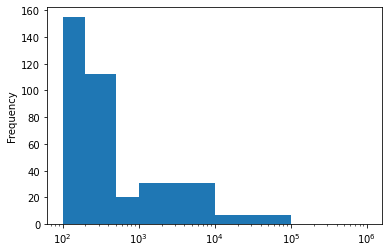

In [10]:
rel_counts.plot(kind="hist", logx=True, bins=[100,200, 500, 1e3,1e4,1e5,1e6])

In [11]:
relative_data_k182.groupby(by=['dut_pos_lead', 'dut_neg_lead']).count()

k182_dcv  temperature  pressure  humidity
dut_pos_lead dut_neg_lead                                           
D4190-3      D4910avg           191          191       191       191
D4190-4      D4910avg           201          201       201       201
D4700+10V    F7001bat           217          217       217       217
D4700-10V    F7001bat           201          201       201       201
D4910-1      D4910avg         11625        11625     11625     11625
             F7001bat          3254         3254      3254      3254
D4910-2      D4910avg          7961         7961      7961      7961
             F7001bat          1844         1844      1844      1844
D4910-3      D4910avg          3346         3346      3346      3346
             F7001bat          1900         1900      1900      1900
D4910-4      D4910avg          3221         3221      3221      3221
             F7001bat          2505         2505      2505      2505
D4910avg     D4190-2            230          230       230       230
             D4190-3            209          209       209       209
             D4190-4            135          135       135       135
             D4910-1           9097         9097      9097      9097
             D4910-2           6680         6680      6680      6680
             D4910-3           2642         2642      2642      2642
             D4910-4           2480         2480      2480      2480
             F7001bat         64280        64280     64280     64280
             F732a1            8456         8456      8456      8456
             F732a2         1174105      1174105   1174105   1174105
D4910avg-bat F7001bat           308          308       308       308
F7001bat     D4700+10V          185          185       185       185
             D4700-10V          198          198       198       198
             D4910-1           3116         3116      3116      3116
             D4910-2           1897         1897      1897      1897
             D4910-3           2279         2279      2279      2279
             D4910-4           1861         1861      1861      1861
             D4910avg         75739        75739     75739     75739
             F732a1            2786         2786      2786      2786
             F732a2           15806        15806     15806     15806
             F732a3            4985         4985      4985      4985
F732a1       D4910avg          7610         7610      7610      7610
             F7001bat          7295         7295      7295      7295
F732a2       D4910avg          8953         8953      8953      8953
             F7001bat          5364         5364      5364      5364
F732a3       F7001bat          6864         6864      6864      6864
short        D4910avg          3368         3368      3368      3368
             F732a2           20150        20150     20150     20150
             F732a3           27876        27876     27876     27876

## Check for sign flip

,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:23:57.145406,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,True,9,-1.0
2023-01-27 23:23:57.435250,D4910avg,F7001bat,-0.000064,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.693478,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:57.953854,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
2023-01-27 23:23:58.217669,D4910avg,F7001bat,-0.000063,28.689062,1030.115562,26.709386,False,9,-1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:11:40.922407,D4910avg,F7001bat,-0.000063,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.214983,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0
2023-01-28 00:11:41.478905,D4910avg,F7001bat,-0.000062,28.384180,1030.115130,26.861672,False,9,-1.0


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,


,dut_neg_lead,dut_pos_lead,k182_dcv,temperature,pressure,humidity,gap,group,sign
datetime,,,,,,,,,
2023-01-27 23:24:49.593494,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:49.856018,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.120381,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.380210,F7001bat,D4910avg,0.000063,28.663281,1030.173685,26.664547,False,9,1.0
2023-01-27 23:24:50.638488,F7001bat,D4910avg,0.000064,28.663281,1030.173685,26.664547,False,9,1.0
...,...,...,...,...,...,...,...,...,...
2023-01-28 00:13:01.709912,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:01.971985,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0
2023-01-28 00:13:02.234607,F7001bat,D4910avg,0.000062,28.361914,1030.128611,26.868205,False,9,1.0


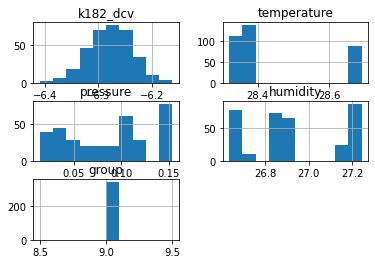

In [12]:
sample = k182_rel_data_cut[(k182_rel_data_cut.group == 9) & ((k182_rel_data_cut.dut_neg_lead == 'D4910avg') | (k182_rel_data_cut.dut_pos_lead == 'D4910avg')) & ((k182_rel_data_cut.dut_neg_lead == 'F7001bat') | (k182_rel_data_cut.dut_pos_lead == 'F7001bat'))].copy()
sample[sample.dut_pos_lead == 'F7001bat'].hist()
sample['sign'] = (sample.k182_dcv / sample.k182_dcv.abs())
res = sample.groupby(['dut_neg_lead', 'dut_pos_lead']).agg({'sign': 'unique'})
res['sign_length'] = res['sign'].apply(lambda r: len(r))
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_pos_lead == 'F7001bat') & (sample.k182_dcv > 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv < 0)])
display(sample[(sample.dut_neg_lead == 'F7001bat') & (sample.k182_dcv > 0)])